In [2]:
!pip install razdel
!pip install pymystem3==0.1.10
!pip install pymorphy2

  Found existing installation: pymystem3 0.2.0
    Uninstalling pymystem3-0.2.0:
      Successfully uninstalled pymystem3-0.2.0
     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 8.2MB 5.2MB/s 


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [55]:
import pandas as pd
from lxml import html
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_distances,cosine_similarity
from sklearn.ensemble import RandomForestClassifier
import gensim
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter,defaultdict
from string import punctuation
from razdel import tokenize as razdel_tokenize
import os
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
%matplotlib inline

morph = MorphAnalyzer()
punct = punctuation+'«»—…“”*№–'
stops = set(stopwords.words('russian'))

def normalize(text):
    
    words = [word.strip(punct) for word in text.lower().split()]
    words = [morph.parse(word)[0].normal_form for word in words if word and word not in stops]

    return ' '.join(words)

def tokenize(text):
    
    
    tokens = [token.text for token in list(razdel_tokenize(text))]
    tokens = [token for token in tokens if token.isalnum()]

    return ' '.join(tokens)


Возьмите данные соревнования по определению перефразирования - http://paraphraser.ru/download/get?file_id=1


In [6]:
corpus_xml = html.fromstring(open('paraphrases.xml', 'rb').read())
texts_1 = []
texts_2 = []
classes = []

for p in corpus_xml.xpath('//paraphrase'):
    texts_1.append(p.xpath('./value[@name="text_1"]/text()')[0])
    texts_2.append(p.xpath('./value[@name="text_2"]/text()')[0])
    classes.append(p.xpath('./value[@name="class"]/text()')[0])
    
data = pd.DataFrame({'text_1':texts_1, 'text_2':texts_2, 'label':classes})

In [7]:
data['text_1_norm'] = data['text_1'].apply(normalize)
data['text_2_norm'] = data['text_2'].apply(normalize)

In [8]:
data.head(2)

,text_1,text_2,label,text_1_norm,text_2_norm
0,Полицейским разрешат стрелять на поражение по ...,Полиции могут разрешить стрелять по хулиганам ...,0,полицейский разрешить стрелять поражение гражд...,полиция мочь разрешить стрелять хулиган травма...
1,Право полицейских на проникновение в жилище ре...,Правила внесудебного проникновения полицейских...,0,право полицейский проникновение жилище решить ...,правило внесудебный проникновение полицейский ...


### 1) Векторизуйте тексты с помощью Word2vec модели, обученной самостоятельно, и с помощью модели, взятой с rusvectores (например вот этой - http://vectors.nlpl.eu/repository/20/180.zip). Обучите 2 модели по определению перефразирования на получившихся векторах и проверьте, что работает лучше.  Word2Vec нужно обучить на отдельном корпусе (не на парафразах). Можно взять данные из семинара или любые другие. 
!!!! ВАЖНО: Оценивать модели нужно с помощью кросс-валидации (в семинаре не кросс-валидация)! Метрика - f1.

Сначала векторизую тексты с помощью модели, взятой с rusvectores

In [9]:
# я скачал вот эту tayga_upos_skipgram_300_2_2019 
# и распаковал архив в папку taiga_w2v_model
pretrained_model = gensim.models.KeyedVectors.load_word2vec_format('model.bin', binary=True)

In [11]:
pretrained_model.most_similar('февраль_NOUN')

[('март_NOUN', 0.9567033052444458),
 ('ноябрь_NOUN', 0.9523458480834961),
 ('декабрь_NOUN', 0.9509049654006958),
 ('апрель_NOUN', 0.949961245059967),
 ('январь_NOUN', 0.9472224712371826),
 ('октябрь_NOUN', 0.937659740447998),
 ('май_NOUN', 0.911928117275238),
 ('июнь_NOUN', 0.9011650681495667),
 ('сентябрь_NOUN', 0.899361252784729),
 ('июль_NOUN', 0.8842827677726746)]

In [ ]:
pretrained_model['февраль_NOUN']

array([ 1.1175872 , -0.22391573,  0.26121503,  0.5476575 ,  0.4481181 ,
       -2.5978436 , -1.7889471 , -0.6384107 , -0.67093   ,  2.4802933 ,
        2.117143  , -1.3266108 ,  0.31270227,  0.5332246 ,  0.6650178 ,
        1.5548006 ,  0.60715556, -1.5675337 , -0.23513682,  1.385819  ,
        1.2787511 , -0.22822474, -1.7990361 ,  0.39526033,  3.1919844 ,
        1.2292011 , -0.2563182 , -2.0753202 ,  1.7657851 , -2.6380384 ,
       -0.95919466,  2.082978  , -2.1801145 ,  0.53563577,  0.15313669,
        0.6777143 , -1.0395736 , -0.9430891 , -0.06782475,  0.07165208,
       -0.18129124, -2.1773202 , -2.1549945 ,  1.1223803 , -0.42965412,
       -1.9258459 , -0.22182733,  0.58437455,  2.0041013 ,  1.1258847 ,
       -0.9572228 , -2.8164334 ,  0.5447553 ,  0.07482819, -0.90745836,
        0.63984466,  1.1124053 ,  0.5535299 ,  0.42505392, -0.6870758 ,
       -1.325869  ,  2.324493  , -3.023114  , -2.581385  , -0.32977122,
        0.5953271 ,  1.1331176 ,  1.9554996 , -4.1206326 ,  0.15

In [10]:
mapping = {}

for line in open('ru-rnc.map.txt'):
    ms, ud = line.strip('\n').split()
    mapping[ms] = ud

In [11]:
mapping

{'A': 'ADJ',
 'ADV': 'ADV',
 'ADVPRO': 'ADV',
 'ANUM': 'ADJ',
 'APRO': 'DET',
 'COM': 'ADJ',
 'CONJ': 'SCONJ',
 'INTJ': 'INTJ',
 'NONLEX': 'X',
 'NUM': 'NUM',
 'PART': 'PART',
 'PR': 'ADP',
 'S': 'NOUN',
 'SPRO': 'PRON',
 'UNKN': 'X',
 'V': 'VERB'}

In [12]:
from pymystem3 import Mystem
m = Mystem()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz


In [13]:
from tqdm import tqdm
def normalize_mystem(text):
    tokens = []
    norm_words = m.analyze(text)
    for norm_word in norm_words:
        if 'analysis' not in norm_word:
            continue
            
        if not len(norm_word['analysis']):
            lemma = norm_word['text']
            pos = 'UNKN'
        else:
            lemma = norm_word["analysis"][0]["lex"].lower().strip()
            pos = norm_word["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
        pos = mapping[pos]
        tokens.append(lemma+'_'+pos)

    return tokens

In [14]:
# test
normalize_mystem('Обучить классификатор парафразов на предобученной модели вам нужно будет дома')

['обучать_VERB',
 'классификатор_NOUN',
 'парафраз_NOUN',
 'на_ADP',
 'предобученный_ADJ',
 'модель_NOUN',
 'вы_PRON',
 'нужно_ADV',
 'быть_VERB',
 'дома_ADV']

In [15]:
def get_embedding(text, model, dim):
    # uncomment if type(text) is string
    #text = text.split()
    
    # чтобы не доставать одно слово несколько раз
    # сделаем счетчик, а потом векторы домножим на частоту
    words = Counter(text)
    total = len(text)
    vectors = np.zeros((len(words), dim))
    
    for i,word in enumerate(words):
        try:
            v = model[word]
            vectors[i] = v*(words[word]/total) # просто умножаем вектор на частоту
        except (KeyError, ValueError):
            continue
    
    if vectors.any():
        vector = np.average(vectors, axis=0)
    else:
        vector = np.zeros((dim))
    
    return vector

In [16]:
from tqdm import tqdm
dim = 300  # как в модели tayga_upos_skipgram_300_2_2019
X_text_1_w2v = np.zeros((len(data['text_1_norm']), dim))
X_text_2_w2v = np.zeros((len(data['text_2_norm']), dim))

for i, text in enumerate(tqdm(data['text_1_norm'].values)):
    X_text_1_w2v[i] = get_embedding(normalize_mystem(text), pretrained_model, dim)

100%|██████████| 7227/7227 [00:03<00:00, 2334.20it/s]


In [17]:
for i, text in enumerate(tqdm(data['text_2_norm'].values)):
    X_text_2_w2v[i] = get_embedding(normalize_mystem(text), pretrained_model, dim)

100%|██████████| 7227/7227 [00:02<00:00, 2462.85it/s]


In [18]:
X_text_w2v = np.concatenate([X_text_1_w2v, X_text_2_w2v], axis=1)

In [19]:
# cross_val - это функция, в которую можно подать
# все данные, классификатор, а остальное она сделаем сама.
from sklearn.model_selection import cross_val_score

In [27]:
y = np.array(data.label)
clf_onpretrained = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=15,
                                          class_weight='balanced')

In [25]:
cross_val_score(clf_onpretrained, X_text_w2v, y, scoring="f1_micro")

array([0.44467497, 0.48340249, 0.5100346 , 0.34256055, 0.37370242])

Теперь обучим модель, на текстах векторизованных с помощью самостоятельно обученного w2v

In [20]:
data_wiki = open('wiki_data.txt', encoding='utf-8').read().splitlines()

In [21]:
data_wiki_norm = [normalize(tokenize(text)) for text in tqdm(data_wiki)]

100%|██████████| 20002/20002 [13:06<00:00, 25.44it/s]


In [22]:
data_wiki_norm = [text for text in tqdm(data_wiki_norm) if text]

100%|██████████| 20002/20002 [00:00<00:00, 1244983.66it/s]


In [23]:
data_wiki_norm[:2]

['новостройка нижегородский область сельский посёлок дивеевский район нижегородский область входить состав сатисский сельсовет посёлок расположить км юг село дивеево 1 км запад город саров право берег река вичкинза правый приток река сатис окружить смешанный лес соединить асфальтовый дорога посёлок цыгановка км грунтовый просёлочный дорога посёлок сатис км название новостройка являться сугубо официальный местный население использовать исключительно альтернативный название хитрый употребляться языковой оборот хитрый ранее использовать название песчаный известковый основать год переселенец соседний село аламасовый нарышкино расположить соответственно 8 14 км запад вознесенский район традиционно посёлок жить рабочий совхоз вперёд центр посёлок сатис возле посёлок расположить карьер активно добывать доломитовый мука бутовый камень настоящий время официально закрытый данные 1978 год посёлок новостройка характеризоваться неперспективный насчитываться 24 хозяйство 43 житель водоснабжение осущ

In [24]:
w2v = gensim.models.Word2Vec([text.split() for text in data_wiki_norm], size=50, sg=1)

In [32]:
w2v.most_similar('язык')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('кантонский', 0.8646734952926636),
 ('диалект', 0.8405657410621643),
 ('восточноломбардский', 0.8163689970970154),
 ('гвичин', 0.8134534358978271),
 ('ломбардский', 0.806578516960144),
 ('атабаскский', 0.7999407052993774),
 ('ден', 0.7876827716827393),
 ('северносаамский', 0.7874000668525696),
 ('кириллица', 0.7829358577728271),
 ('славяносербский', 0.7816162109375)]

In [25]:
def get_embedding_split(text, model, dim):
    text = text.split()
    
    # чтобы не доставать одно слово несколько раз
    # сделаем счетчик, а потом векторы домножим на частоту
    words = Counter(text)
    total = len(text)
    vectors = np.zeros((len(words), dim))
    
    for i,word in enumerate(words):
        try:
            v = model[word]
            vectors[i] = v*(words[word]/total) # просто умножаем вектор на частоту
        except (KeyError, ValueError):
            continue
    
    if vectors.any():
        vector = np.average(vectors, axis=0)
    else:
        vector = np.zeros((dim))
    
    return vector

In [84]:
from tqdm import tqdm
dim = 50 
X_text_1_w2v_my = np.zeros((len(data['text_1_norm']), dim))
X_text_2_w2v_my = np.zeros((len(data['text_2_norm']), dim))

for i, text in enumerate(data['text_1_norm'].values):
    X_text_1_w2v_my[i] = get_embedding_split(text, w2v, dim)
    
for i, text in enumerate(data['text_2_norm'].values):
    X_text_2_w2v_my[i] = get_embedding_split(text, w2v, dim)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [86]:
X_text_w2v_my = np.concatenate([X_text_1_w2v_my, X_text_2_w2v_my], axis=1)

In [87]:
y = np.array(data.label)
clf_onmine = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=15,
                                    class_weight='balanced')

In [90]:
cross_val_score(clf_onmine, X_text_w2v_my, y, scoring="f1_micro", cv=3)

array([0.46450809, 0.4898298 , 0.38273142])

In [91]:
cross_val_score(clf_onpretrained, X_text_w2v, y, scoring="f1_micro", cv=3)

array([0.44458281, 0.49024491, 0.39726027])

На pretrained модели из rusvectores получилось получше в среднем, чем на той, где w2v я делала свой. **UPD:** я еще несколько раз прогнала, поэкспериментировала с количеством сплитов в cv и поняла, что на самом деле примерно одинаково получается

### 2) Преобразуйте тексты в векторы в каждой паре 5 методами  - SVD, NMF, Word2Vec (свой и  русвекторовский), Fastext. У вас должно получиться 5 пар векторов для каждой строчки в датасете. Между векторами каждой пары вычислите косинусную близость (получится 5 чисел для каждой пары). 

In [92]:
X_text_1_w2v_my.shape

(7227, 50)

In [93]:
data.shape

(7227, 7)

In [94]:
my_w2v_cos = [cosine_similarity([v1], [v2])[0][0] for v1, v2 in zip(X_text_1_w2v_my, X_text_2_w2v_my)]

In [95]:
pretrain_w2v_cos = [cosine_similarity([v1], [v2])[0][0] for v1, v2 in zip(X_text_1_w2v, X_text_2_w2v)]
len(pretrain_w2v_cos)

7227

In [96]:
data['my_w2v_cos'] = my_w2v_cos
data['pretrain_w2v_cos'] = pretrain_w2v_cos

In [98]:
data.head(2)

,text_1,text_2,label,text_1_norm,text_2_norm,my_w2v_cos,pretrain_w2v_cos
0,Полицейским разрешат стрелять на поражение по ...,Полиции могут разрешить стрелять по хулиганам ...,0,полицейский разрешить стрелять поражение гражд...,полиция мочь разрешить стрелять хулиган травма...,0.909174,0.684432
1,Право полицейских на проникновение в жилище ре...,Правила внесудебного проникновения полицейских...,0,право полицейский проникновение жилище решить ...,правило внесудебный проникновение полицейский ...,0.939108,0.769161


Теперь делаем векторизацию c SVD

In [100]:
tfidf = TfidfVectorizer(min_df=3, max_df=0.4, max_features=1000)
tfidf.fit(pd.concat([data['text_1_norm'], data['text_2_norm']]))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.4, max_features=1000,
                min_df=3, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [101]:
svd = TruncatedSVD(200)

X_text_1_svd = svd.fit_transform(tfidf.transform(data['text_1_norm']))
X_text_2_svd = svd.fit_transform(tfidf.transform(data['text_2_norm']))
X_text_2_svd.shape

(7227, 200)

In [ ]:
svd_cos = [cosine_similarity([v1], [v2])[0][0] for v1, v2 in zip(X_text_1_svd, X_text_2_svd)]


In [103]:
data['svd_cos'] = svd_cos
data.head(2)

,text_1,text_2,label,text_1_norm,text_2_norm,my_w2v_cos,pretrain_w2v_cos,svd_cos
0,Полицейским разрешат стрелять на поражение по ...,Полиции могут разрешить стрелять по хулиганам ...,0,полицейский разрешить стрелять поражение гражд...,полиция мочь разрешить стрелять хулиган травма...,0.909174,0.684432,0.023741
1,Право полицейских на проникновение в жилище ре...,Правила внесудебного проникновения полицейских...,0,право полицейский проникновение жилище решить ...,правило внесудебный проникновение полицейский ...,0.939108,0.769161,0.073409


Теперь делаем векторизацию c NMF

In [104]:
nmf = NMF(100)
X_text_1_nmf = nmf.fit_transform(tfidf.transform(data['text_1_norm']))
X_text_2_nmf = nmf.fit_transform(tfidf.transform(data['text_2_norm']))

In [105]:
X_text_1_nmf.shape

(7227, 100)

In [106]:
nmf_cos = [cosine_similarity([v1], [v2])[0][0] for v1, v2 in zip(X_text_1_nmf, X_text_2_nmf)]


In [110]:
data['nmf_cos'] = nmf_cos
data.head(2)

,text_1,text_2,label,text_1_norm,text_2_norm,my_w2v_cos,pretrain_w2v_cos,svd_cos,nmf_cos
0,Полицейским разрешат стрелять на поражение по ...,Полиции могут разрешить стрелять по хулиганам ...,0,полицейский разрешить стрелять поражение гражд...,полиция мочь разрешить стрелять хулиган травма...,0.909174,0.684432,0.023741,0.001409
1,Право полицейских на проникновение в жилище ре...,Правила внесудебного проникновения полицейских...,0,право полицейский проникновение жилище решить ...,правило внесудебный проникновение полицейский ...,0.939108,0.769161,0.073409,0.000000


Теперь делаем векторизацию с Fasttext

In [111]:
fast_text = gensim.models.FastText([text.split() for text in data_wiki_norm], size=50, 
                                   min_n=4, max_n=8) 

In [112]:
fast_text.most_similar('язык')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('языкова', 0.9599191546440125),
 ('язычок', 0.958702027797699),
 ('языковед', 0.9430063962936401),
 ('диалект', 0.8220722079277039),
 ('поэзия', 0.7375847697257996),
 ('алфавит', 0.7257299423217773),
 ('википедия', 0.7244200706481934),
 ('диалог', 0.7164435982704163),
 ('грамматик', 0.709918737411499),
 ('словарь', 0.7093546986579895)]

In [113]:
dim = 50 
X_text_1_fasttext = np.zeros((len(data['text_1_norm']), dim))
X_text_2_fasttext = np.zeros((len(data['text_2_norm']), dim))

for i, text in enumerate(data['text_1_norm'].values):
    X_text_1_fasttext[i] = get_embedding_split(text, fast_text, dim)
    
for i, text in enumerate(data['text_2_norm'].values):
    X_text_2_fasttext[i] = get_embedding_split(text, fast_text, dim)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [118]:
X_text_2_fasttext.shape

(7227, 50)

In [ ]:
fasttext_cos = [cosine_similarity([v1], [v2])[0][0] for v1, v2 in zip(X_text_1_fasttext, X_text_2_fasttext)]


In [120]:
data['fasttext_cos'] = fasttext_cos
data.head(3)

,text_1,text_2,label,text_1_norm,text_2_norm,my_w2v_cos,pretrain_w2v_cos,svd_cos,nmf_cos,fasttext_cos
0,Полицейским разрешат стрелять на поражение по ...,Полиции могут разрешить стрелять по хулиганам ...,0,полицейский разрешить стрелять поражение гражд...,полиция мочь разрешить стрелять хулиган травма...,0.909174,0.684432,0.023741,0.001409,0.832776
1,Право полицейских на проникновение в жилище ре...,Правила внесудебного проникновения полицейских...,0,право полицейский проникновение жилище решить ...,правило внесудебный проникновение полицейский ...,0.939108,0.769161,0.073409,0.000000,0.833987
2,Президент Египта ввел чрезвычайное положение в...,Власти Египта угрожают ввести в стране чрезвыч...,0,президент египет ввести чрезвычайный положение...,власть египет угрожать ввести страна чрезвычай...,0.946575,0.826440,-0.028124,0.000040,0.785734


5 колонок с косинусными близостями между парами векторизованных текстов -- получились

### Постройте обучающую выборку из этих близостей . Обучите любую модель (Логрег, Рандом форест или что-то ещё) на этой выборке и оцените качество на кросс-валидации (используйте микросреднюю f1-меру).  Попробуйте улучить метрику, изменив параметры в методах векторизации.
!!УТОЧНЕНИЕ: модель нужно обучить сразу на всех 5 близостях, а не по 1 модели на каждой близости!

In [125]:
clf_final = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=15,
                                    class_weight='balanced')

In [126]:
y = np.array(data.label)

In [127]:
X = data[['my_w2v_cos', 'pretrain_w2v_cos', 'svd_cos', 'nmf_cos', 'fasttext_cos']]
X.head()

,my_w2v_cos,pretrain_w2v_cos,svd_cos,nmf_cos,fasttext_cos
0,0.909174,0.684432,0.023741,0.001409,0.832776
1,0.939108,0.769161,0.073409,0.000000,0.833987
2,0.946575,0.826440,-0.028124,0.000040,0.785734
3,0.800620,0.321407,-0.129837,0.002513,0.453214
4,0.915678,0.675009,-0.103641,0.000685,0.304416


In [128]:
cross_val_score(clf_final, X, y, scoring="f1_micro", cv=4)

array([0.54454898, 0.58716104, 0.53458771, 0.48726467])

По заданию нужно улучшить метрику изменив парметры в методах векторизации. Чтобы не тыкать пальцем в небо попробуем сначал понять какая из колонок с косинусной близостью меньше всего вкладывается в результат модели.

Feature: 0, Score: 0.43064
Feature: 1, Score: 0.33942
Feature: 2, Score: 0.04938
Feature: 3, Score: 0.03953
Feature: 4, Score: 0.14103


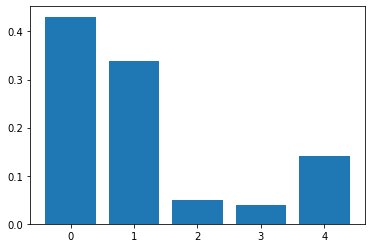

In [130]:
from matplotlib import pyplot

clf_final.fit(X, y)
# get importance
importance = clf_final.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Получается, что методы под номером 2 и 3, то есть `'svd_cos', 'nmf_cos'` надо улучшить

In [131]:
tfidf = TfidfVectorizer(min_df=4, max_df=0.5, max_features=1000)
tfidf.fit(pd.concat([data['text_1_norm'], data['text_2_norm']]))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.5, max_features=1000,
                min_df=4, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [132]:
svd = TruncatedSVD(100)  # было 200

X_text_1_svd = svd.fit_transform(tfidf.transform(data['text_1_norm']))
X_text_2_svd = svd.fit_transform(tfidf.transform(data['text_2_norm']))
X_text_2_svd.shape

(7227, 100)

In [133]:
new_svd_cos = [cosine_similarity([v1], [v2])[0][0] for v1, v2 in zip(X_text_1_svd, X_text_2_svd)]


In [134]:
data['svd_cos'] = new_svd_cos
data.head(2)

,text_1,text_2,label,text_1_norm,text_2_norm,my_w2v_cos,pretrain_w2v_cos,svd_cos,nmf_cos,fasttext_cos
0,Полицейским разрешат стрелять на поражение по ...,Полиции могут разрешить стрелять по хулиганам ...,0,полицейский разрешить стрелять поражение гражд...,полиция мочь разрешить стрелять хулиган травма...,0.909174,0.684432,-0.153809,0.001409,0.832776
1,Право полицейских на проникновение в жилище ре...,Правила внесудебного проникновения полицейских...,0,право полицейский проникновение жилище решить ...,правило внесудебный проникновение полицейский ...,0.939108,0.769161,-0.214321,0.000000,0.833987


Теперь подкрутим параметры NMF

In [135]:
nmf = NMF(200)  # было 100
X_text_1_nmf = nmf.fit_transform(tfidf.transform(data['text_1_norm']))
X_text_2_nmf = nmf.fit_transform(tfidf.transform(data['text_2_norm']))

In [138]:
X_text_1_nmf

array([[0.00042703, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.10237149, ..., 0.        , 0.00173045,
        0.        ],
       [0.        , 0.        , 0.07195858, ..., 0.        , 0.00040248,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [139]:
new_nmf_cos = [cosine_similarity([v1], [v2])[0][0] for v1, v2 in zip(X_text_1_nmf, X_text_2_nmf)]


In [142]:
new_nmf_cos[:10]

[0.0,
 0.0,
 0.016526320886776132,
 0.03107891356176823,
 0.0005854977653614565,
 0.0,
 0.0,
 0.007695944253878257,
 0.0014242944624586896,
 0.008266848902475317]

In [143]:
data['nmf_cos'] = new_nmf_cos
data.head(3)

,text_1,text_2,label,text_1_norm,text_2_norm,my_w2v_cos,pretrain_w2v_cos,svd_cos,nmf_cos,fasttext_cos
0,Полицейским разрешат стрелять на поражение по ...,Полиции могут разрешить стрелять по хулиганам ...,0,полицейский разрешить стрелять поражение гражд...,полиция мочь разрешить стрелять хулиган травма...,0.909174,0.684432,-0.153809,0.000000,0.832776
1,Право полицейских на проникновение в жилище ре...,Правила внесудебного проникновения полицейских...,0,право полицейский проникновение жилище решить ...,правило внесудебный проникновение полицейский ...,0.939108,0.769161,-0.214321,0.000000,0.833987
2,Президент Египта ввел чрезвычайное положение в...,Власти Египта угрожают ввести в стране чрезвыч...,0,президент египет ввести чрезвычайный положение...,власть египет угрожать ввести страна чрезвычай...,0.946575,0.826440,-0.085504,0.016526,0.785734


In [144]:
clf_final2 = RandomForestClassifier(n_estimators=100, max_depth=7,
                                    min_samples_leaf=15, class_weight='balanced')
y = np.array(data.label)
X2 = data[['my_w2v_cos', 'pretrain_w2v_cos', 'svd_cos', 'nmf_cos', 'fasttext_cos']]
X2.head()

,my_w2v_cos,pretrain_w2v_cos,svd_cos,nmf_cos,fasttext_cos
0,0.909174,0.684432,-0.153809,0.000000,0.832776
1,0.939108,0.769161,-0.214321,0.000000,0.833987
2,0.946575,0.826440,-0.085504,0.016526,0.785734
3,0.800620,0.321407,0.003511,0.031079,0.453214
4,0.915678,0.675009,0.142779,0.000585,0.304416


In [145]:
cross_val_score(clf_final2, X2, y, scoring="f1_micro", cv=4)

array([0.55063641, 0.58494743, 0.53514112, 0.48781838])

а предыдущий f1  такой был:

In [146]:
cross_val_score(clf_final, X, y, scoring="f1_micro", cv=4)

array([0.53901494, 0.58882125, 0.53680133, 0.49169435])

В общем снова ничего не поменялось. Возможно, если глубже поисследовать именно то, какие кластеры создают NMF и SVD на наших парафразах и посмотреть где затыки, то ситуация улучшится. Наример, заменить все имена собственные или все числа на какой-то один токен и попробовать заново векторизовать.